In [1]:
# Additional imports are required
import os 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.data.multi_modal import MultiModalData

import logging
logging.raiseExceptions = False

# FEDOT Case

This is AutoML model from https://github.com/aimclub/FEDOT 
They created AutoML for Time Series. And we'll try it. 

In [2]:
# Load prerpocessed dataset 
df_aqi = pd.read_csv("AQI_dataset.csv", parse_dates=['Datetime'], index_col=['Datetime'])

<AxesSubplot: xlabel='Datetime'>

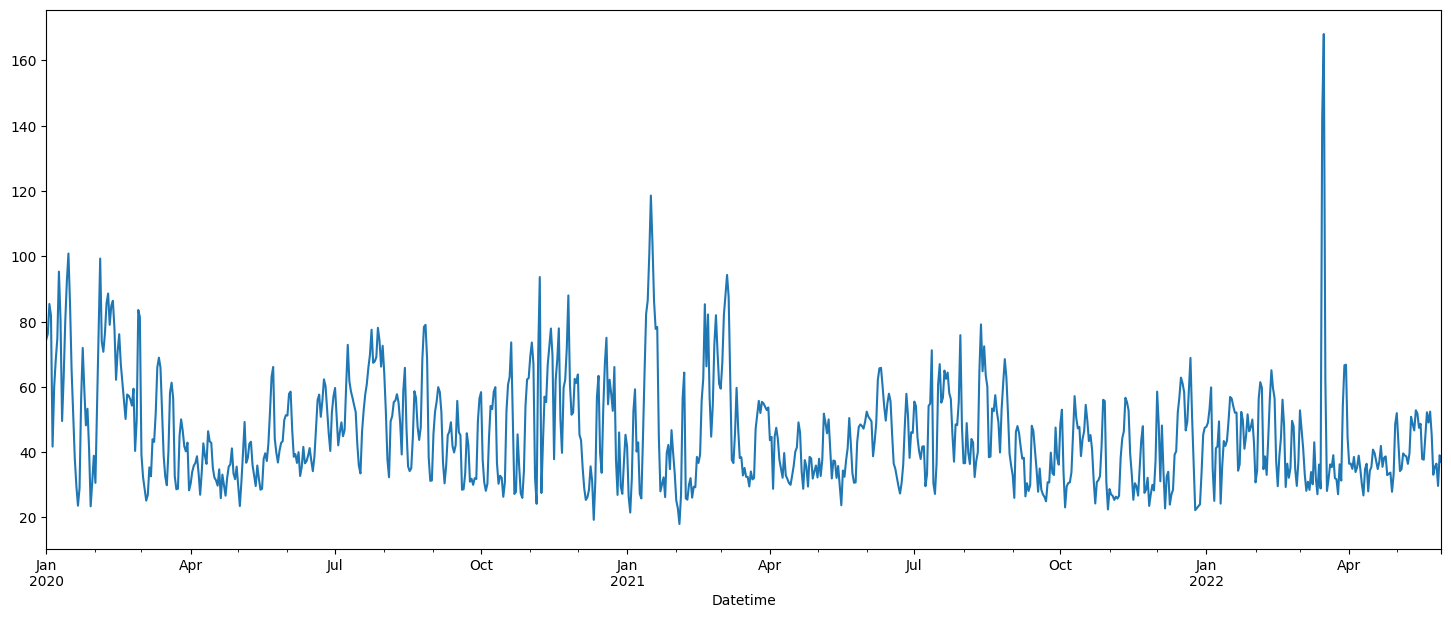

In [3]:
# resample it as daily
df_daily = df_aqi.resample('D').mean().interpolate()
df_daily["AQI"].plot()

In [13]:
# Train test split
n_train = int(df_daily.shape[0] * 0.77)
train, test = df_daily.iloc[:n_train], df_daily.iloc[n_train:]

In [211]:
def make_forecast(train_data, len_forecast: int, window_size: int, final_model: str = 'ridge'):
    """
    Function for predicting values in a time series
    
    :param train_data: one-dimensional numpy array to train pipeline
    :param len_forecast: amount of values for predictions
    :param window_size: moving window size
    :param final_model: model in the root node

    :return predicted_values: numpy array, forecast of model
    """
    
    # Here we define which task should we use, here we also define two main forecast length
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

    # Prepare data to train the model
    train_input = InputData(idx=np.arange(0, len(train_data)),
                            features=train_data,
                            target=train_data,
                            task=task,
                            data_type=DataTypesEnum.ts)

    # Prepare input data for prediction part
    start_forecast = len(train_data)
    end_forecast = start_forecast + len_forecast
    # Create forecast indices 
    forecast_idx = np.arange(start_forecast, end_forecast)
    predict_input = InputData(idx=forecast_idx,
                              features=train_data,
                              target=test["AQI"],
                              task=task,
                              data_type=DataTypesEnum.ts)
    
    # Create a pipeline "lagged -> " 
    node_lagged = PrimaryNode('lagged')
    
    # Define parameters to certain node 
    node_lagged.custom_params = {'window_size': window_size}
    node_ridge = SecondaryNode(final_model, nodes_from=[node_lagged])
    ridge_pipeline = Pipeline(node_ridge)

    # Fit pipeline
    ridge_pipeline.fit(train_input)

    # Predict. Pipeline return OutputData object 
    predicted_output = ridge_pipeline.predict(predict_input)

    # Convert forecasted values into one-dimensional array
    forecast = np.ravel(np.array(predicted_output.predict))

    return forecast


In [212]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15)
    plt.grid()
    plt.show()

In [213]:
# Make forecast
predicted_values = make_forecast(train_data = train["AQI"], 
                                 len_forecast = 203,
                                 window_size = 400)



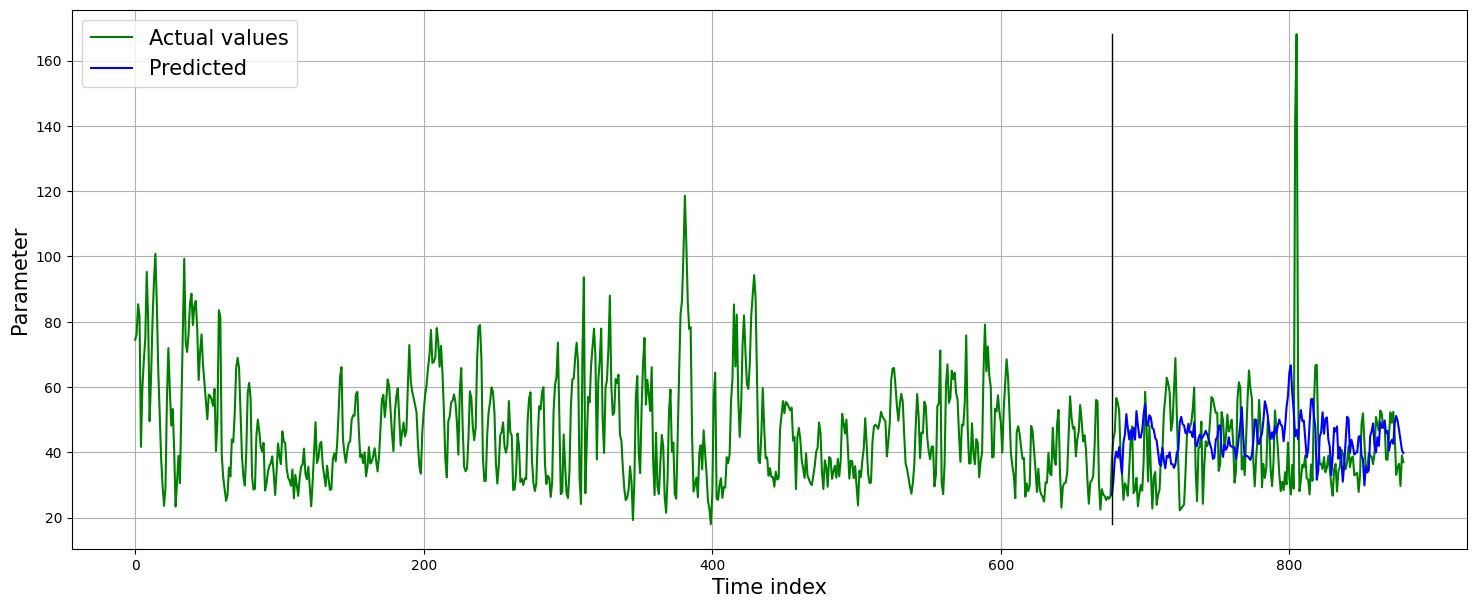

In [214]:
plot_results(actual_time_series = df_daily["AQI"],
             predicted_values = predicted_values, 
             len_train_data = len(train))

Look like not very good, but this model made prediction for all test set

In [215]:
print(f'Mean absolute error: {mean_absolute_error(test["AQI"], predicted_values):.3f}')

Mean absolute error: 12.523


In [216]:
print(f'Root mean squared error: {mean_squared_error(test["AQI"], predicted_values, squared=False):.3f}')

Root mean squared error: 17.649


We can try more complex model

In [217]:
# First level
node_lagged_1 = PrimaryNode('lagged')
node_lagged_1.custom_params = {'window_size': 3}
node_lagged_2 = PrimaryNode('lagged')
node_lagged_2.custom_params = {'window_size': 450}

# Second level
node_knnreg = SecondaryNode('knnreg', nodes_from=[node_lagged_1])
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_2])

# Third level - root node
node_final = SecondaryNode('ridge', nodes_from=[node_knnreg, node_ridge])
complex_pipeline = Pipeline(node_final)

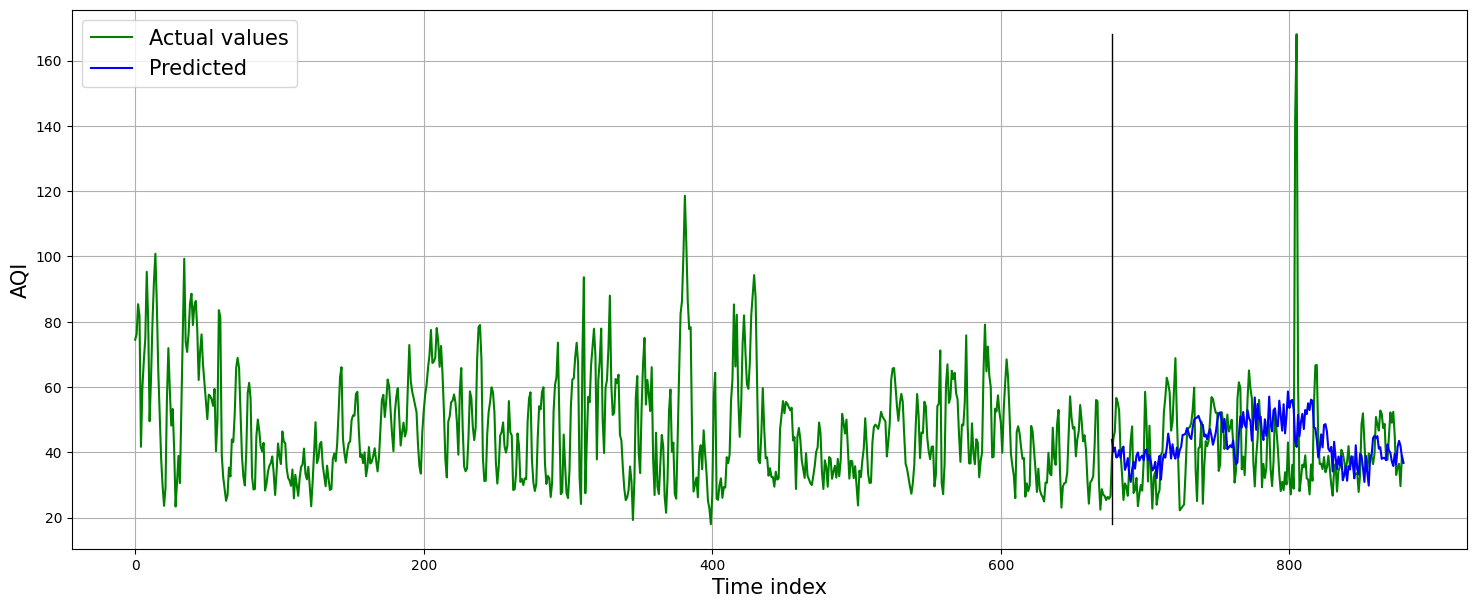

Mean absolute error: 10.945
Root mean squared error: 16.497


In [218]:
# Here we define which task should we use, here we also define two main forecast length
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=203))

# Prepare data to train the model
train_input = InputData(idx=np.arange(0, len(train)),
                        features=train["AQI"],
                        target=train["AQI"],
                        task=task,
                        data_type=DataTypesEnum.ts)

# Prepare input data for prediction part
start_forecast = len(train)
end_forecast = start_forecast + len_forecast
# Create forecast indices 
forecast_idx = np.arange(start_forecast, end_forecast)
predict_input = InputData(idx=forecast_idx,
                          features=train["AQI"],
                          target=None,
                          task=task,
                          data_type=DataTypesEnum.ts)

# Fit pipeline
complex_pipeline.fit(train_input)

# Predict. Pipeline return OutputData object 
predicted_output = complex_pipeline.predict(predict_input)

# Convert forecasted values into one-dimensional array
predicted_values = np.ravel(np.array(predicted_output.predict))

# Plot predictions and true values
plot_results(actual_time_series = df_daily["AQI"],
             predicted_values = predicted_values, 
             len_train_data = len(train),
             y_name = 'AQI')

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test["AQI"], predicted_values):.3f}')
print(f'Root mean squared error: {mean_squared_error(test["AQI"], predicted_values, squared=False):.3f}')

Errors are still bigger than from naive model

FEDOT can add one more feature. We try all consistently

In [6]:
def make_forecast(train, len_forecast: int):
    """
    Function for predicting values in a time series
    
    :param train_data: one-dimensional numpy array to train pipeline
    :param len_forecast: amount of values for predictions

    :return predicted_values: forecast of model
    """
    

    # Data for lagged transformation
    task = Task(TaskTypesEnum.ts_forecasting,
                    TsForecastingParams(forecast_length=len_forecast))
    train_lagged = InputData(idx=np.arange(0, len(train)),
                             features=train['AQI'],
                             target=train['AQI'],
                             task=task,
                             data_type=DataTypesEnum.ts)
    start_forecast = len(train)
    end_forecast = start_forecast + len_forecast
    predict_lagged = InputData(idx=np.arange(start_forecast, end_forecast),
                               features=train,
                               target=test['AQI'],
                               task=task,
                               data_type=DataTypesEnum.ts)
    
    
    # Data for exog operation
    train_exog = InputData(idx=np.arange(0, len(train)),
                           features=train['PM2.5_avg'],
                           target=train['AQI'],
                           task=task,
                           data_type=DataTypesEnum.ts)
    start_forecast = len(train)
    end_forecast = start_forecast + len_forecast
    predict_exog = InputData(idx=np.arange(start_forecast, end_forecast),
                              features=test['PM2.5_avg'],
                              target=test['AQI'],
                              task=task,
                              data_type=DataTypesEnum.ts)


    # Data for exog operation
    train_exog_PM10 = InputData(idx=np.arange(0, len(train)),
                           features=train['PM10_avg'],
                           target=train['AQI'],
                           task=task,
                           data_type=DataTypesEnum.ts)
    start_forecast = len(train)
    end_forecast = start_forecast + len_forecast
    predict_exog_PM10 = InputData(idx=np.arange(start_forecast, end_forecast),
                              features=test['PM10_avg'],
                              target=test['AQI'],
                              task=task,
                              data_type=DataTypesEnum.ts)

    # Data for exog operation
    train_exog_CO = InputData(idx=np.arange(0, len(train)),
                           features=train['CO_avg'],
                           target=train['AQI'],
                           task=task,
                           data_type=DataTypesEnum.ts)
    start_forecast = len(train)
    end_forecast = start_forecast + len_forecast
    predict_exog_CO = InputData(idx=np.arange(start_forecast, end_forecast),
                              features=test['CO_avg'],
                              target=test['AQI'],
                              task=task,
                              data_type=DataTypesEnum.ts)

    # Data for exog operation
    train_exog_O3 = InputData(idx=np.arange(0, len(train)),
                           features=train['O3_avg'],
                           target=train['AQI'],
                           task=task,
                           data_type=DataTypesEnum.ts)
    start_forecast = len(train)
    end_forecast = start_forecast + len_forecast
    predict_exog_O3 = InputData(idx=np.arange(start_forecast, end_forecast),
                              features=test['O3_avg'],
                              target=test['AQI'],
                              task=task,
                              data_type=DataTypesEnum.ts)


    # Data for exog operation
    train_exog_NO2 = InputData(idx=np.arange(0, len(train)),
                           features=train['NO2_avg'],
                           target=train['AQI'],
                           task=task,
                           data_type=DataTypesEnum.ts)
    start_forecast = len(train)
    end_forecast = start_forecast + len_forecast
    predict_exog_NO2 = InputData(idx=np.arange(start_forecast, end_forecast),
                              features=test['NO2_avg'],
                              target=test['AQI'],
                              task=task,
                              data_type=DataTypesEnum.ts)

    # Data for exog operation
    train_exog_SO2 = InputData(idx=np.arange(0, len(train)),
                           features=train['SO2_avg'],
                           target=train['AQI'],
                           task=task,
                           data_type=DataTypesEnum.ts)
    start_forecast = len(train)
    end_forecast = start_forecast + len_forecast
    predict_exog_SO2 = InputData(idx=np.arange(start_forecast, end_forecast),
                              features=test['SO2_avg'],
                              target=test['AQI'],
                              task=task,
                              data_type=DataTypesEnum.ts)
    
    train_dataset = MultiModalData({
        'lagged': train_lagged,
        'exog_ts': train_exog,
    #     'exog_ts': train_exog_PM10,
    #     'exog_ts': train_exog_CO,
    #     'exog_ts': train_exog_O3,
    #     'exog_ts': train_exog_NO2,
    #     'exog_ts': train_exog_SO2
    })


    predict_dataset = MultiModalData({
        'lagged': predict_lagged,
        'exog_ts': predict_exog,
    #     'exog_ts': predict_exog_PM10,
    #     'exog_ts': predict_exog_CO,
    #     'exog_ts': predict_exog_O3,
    #     'exog_ts': predict_exog_NO2,
    #     'exog_ts': predict_exog_SO2
    })
    
    # Create a pipeline with different data sources in th nodes 
    node_lagged = PrimaryNode('lagged')
    node_exog = PrimaryNode('exog_ts')
    node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged, node_exog])
    exog_pipeline = Pipeline(node_ridge)

    # Fit it
    exog_pipeline.fit(train_dataset)

    # Predict
    predicted = exog_pipeline.predict(predict_dataset)
    predicted_values = np.ravel(np.array(predicted.predict))
    
    return predicted_values

In [191]:
predicted_values = make_forecast(train, 203)

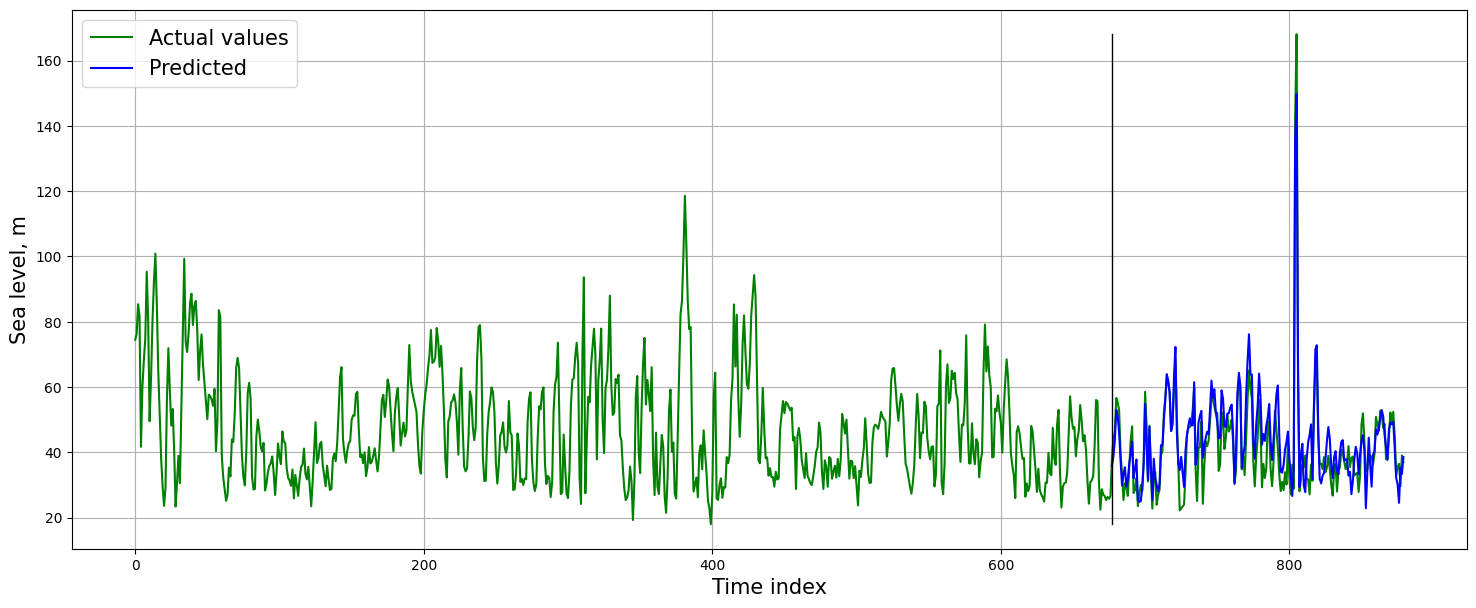

In [192]:
# Plot predictions and true values
plot_results(actual_time_series = df_daily["AQI"],
             predicted_values = predicted_values, 
             len_train_data = len(train),
             y_name = 'Sea level, m')


In [193]:
# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test["AQI"], predicted_values):.3f}')

Mean absolute error: 5.121


In [194]:
print(f'Mean squared error: {mean_squared_error(test["AQI"], predicted_values, squared=False):.3f}')

Mean squared error: 6.431


Excellent result for forecasting whole test set. But we can't compare its with another model. As we can't predict just one day with FEDOT. We'll predict two days, but for error use first day.

In [195]:
predictions = []

for i in range(len(test)):
    pred = make_forecast(train, 2)
    predictions.append(pred)

    train = pd.concat([train, test[i]])


In [196]:
preds = pd.DataFrame(predictions, columns=['first', 'second'])

In [197]:
print(f'Mean absolute error: {mean_absolute_error(test["AQI"], preds["first"]):.3f}')

Mean absolute error: 9.788


In [198]:
print(f'Root mean squared error: {mean_squared_error(test["AQI"], preds["first"], squared=False):.3f}')

Root mean squared error: 15.733


For first day, result not very good. We have a lot of questions, why result for whole test set is so good.

### For several days

In [42]:
# Train test split
n_train = int(df_daily.shape[0] * 0.77)
train, test = df_daily.iloc[:n_train], df_daily.iloc[n_train:]

In [43]:
predictions = []

for i in range(len(test)-4):
    pred = make_forecast(train, 5)
    predictions.append(pred)

    train = train.append(test.iloc[i])


In [50]:
print(f'Mean absolute error: {mean_absolute_error(np.array([np.array(window) for window in test.AQI.rolling(window=5)][4:]), np.array(predictions)):.3f}')

Mean absolute error: 11.709


In [51]:
print(f'Root mean squared error: {mean_squared_error(np.array([np.array(window) for window in test.AQI.rolling(window=5)][4:]), np.array(predictions), squared=False):.3f}')

Root mean squared error: 18.198
